In [33]:
import sctop as top
import pandas as pd
from taigapy import create_taiga_client_v3
import numpy as np
import io
import os
import seaborn as sns

from numpy.random import default_rng

rng = default_rng(2
                  024)

tc = create_taiga_client_v3()

In [82]:
class OrderParamClassifier:
    def __init__(self, expr, markers, num_samples):
        """

        :param expr: Expression data.
            Format: Pandas DataFrame.
            Rows: samples (index)
            Columns: genes (ensg).
            Entries: log2(tpm+1)
        :param markers: Cell types
            Format: Pandas Series
            Rows: samples (index)
            Columns: metadata
            Entries: plain text. at least one cell/disease type column
        :param num_samples: Int. Number of samples to take from each marker for training

        """
        self.expr = expr
        self.markers = markers
        self.num_samples = num_samples
        self.basis = pd.DataFrame()

        self.harmonize_samples()

    def load_expr(self):
        pass

    def load_meta(self):
        pass

    def harmonize_samples(self):
        shared_idxs = self.expr.index.intersection(self.markers.index)
        self.expr = self.expr.loc[shared_idxs]
        self.markers = self.markers.loc[shared_idxs]

        marker_counts = self.markers.value_counts()
        valid_markers = marker_counts[marker_counts > self.num_samples].index
        self.markers = self.markers[self.markers.isin(valid_markers)]

    def train(self):
        expr_list = []
        train_ids = []

        labels = self.markers.unique().tolist()

        for curr_type in labels:
            curr_type_ids = self.markers[self.markers == curr_type].index
            train_sample = rng.choice(curr_type_ids, self.num_samples, replace=False)
            train_ids += [train_sample]

            curr_expr = self.expr.loc[train_sample]
            curr_processed = top.process(2 ** curr_expr.T - 1, average=True)
            expr_list.append(curr_processed)

        train_ids = np.concatenate(train_ids)
        self.basis = pd.concat(expr_list, axis=1)
        self.basis.columns = labels
        self.basis.index = self.basis.index.rename('gene')

        accuracies, test_labels, projections, eta = self.validate_training(train_ids)
        return train_ids, accuracies, test_labels, projections, eta

    def score(self, test_data):
        processed = top.process(2 ** test_data.T - 1)
        projections, _, eta = top.score(self.basis, processed, full_output=True)
        return projections, eta

    def validate_training(self, train_ids):
        test_ids = self.markers.index.difference(self.markers.loc[train_ids].index)
        projections, eta = self.score(self.expr.loc[test_ids])

        return self.check_acc(projections) + (projections, eta)

    def check_acc(self, projections, skip_fun=None, specification_value=0.1):
        if not skip_fun:
            def skip_fun(sample, ann):
                return False

        accuracies = {'top1': 0,
                      'top3': 0,
                      'unspecified': 0
                      }

        num_tested = 0

        labels = []

        for sample_id, sample_projections in projections.iteritems():

            types_sorted_by_projections = sample_projections.sort_values(ascending=False).index
            true_type = self.markers.loc[sample_id]

            if skip_fun(sample_id, self.markers):
                continue

            num_tested += 1

            top_type = types_sorted_by_projections[0]

            if sample_projections.max() < specification_value:
                accuracies['unspecified'] += 1

            if top_type == true_type:
                accuracies['top1'] += 1
            if true_type in types_sorted_by_projections[:3]:
                accuracies['top3'] += 1

            true_idx_tup = (true_type, true_type, true_type)
            label_df = pd.DataFrame(data=true_idx_tup, columns=['true_type'])
            label_df['labeled_type'] = types_sorted_by_projections[:3]
            label_df.index.name = 'place'
            labels.append(label_df.reset_index())

        print('Accuracy statistics for {} test samples and {} training samples per cancer type'.format(num_tested,
                                                                                                       self.num_samples))

        for key, value in accuracies.items():
            print('{}: {:.2f}%'.format(key, 100 * value / num_tested))

        return accuracies, pd.concat(labels, ignore_index=True)


def get_gene_map(tc, get_transcripts=False):
    hgnc = tc.get(name='hgnc-87ab', version=7, file='hgnc_complete_set')
    hgnc = hgnc[['hgnc_id', 'symbol', 'locus_group', 'locus_type', 'entrez_id', 'ensembl_gene_id']]
    hgnc['depmap'] = hgnc.symbol + ' (' + hgnc.entrez_id.fillna(-1).astype(int).astype(str) + ')'
    hgnc.loc[(hgnc.symbol.isna()) | (hgnc.entrez_id.isna()), 'depmap'] = np.nan
    if get_transcripts:
        ensembl = generateGeneNames(attributes=['ensembl_transcript_id'], cache_folder=os.getcwd() + '/ensemblecache/')
        print(ensembl)
        hgnc = pd.merge(hgnc,
                        ensembl.set_index('ensembl_gene_id').ensembl_transcript_id,
                        left_on='ensembl_gene_id', right_index=True)
    return hgnc


oncotree = tc.get(name="oncotree-42c7", version=1, file="oncotree").set_index("code")
oncotree=oncotree.reset_index()

# Step 1: Find names with more than one unique OncoTree code
multiple_codes = oncotree.groupby('name')['code'].nunique()
names_with_multiple_codes = multiple_codes[multiple_codes > 1].index

# Update the 'name' column in the oncotree DataFrame
def update_name(row):
    if row['name'] in names_with_multiple_codes:
        return f"{row['name']} ({row['tissue']})"
    return row['name']

oncotree['name'] = oncotree.apply(update_name, axis=1)
oncotree=oncotree.set_index('code')

def process_oncocode(code,oncotree):
    """
    Generates a disease annotation given an oncotree code
    @param code: (str) oncotree code
    @return: (Pandas Series) Disease lineage and subtype associated with the oncotree code
    """
    if code in oncotree.index:
        row = oncotree.loc[code]
        return pd.Series({"lineage": row.tissue, "subtype": row["name"]})
    else:
        return pd.Series({"lineage": np.nan, "subtype": np.nan})

def get_sublineage(code, oncotree):
    """
    Takes an Oncotree code and returns the node on the Oncotree that is just below the lineage level.
    
    Parameters:
    - code (str): The Oncotree code for which to find the sublineage node.
    - oncotree (pd.DataFrame): A DataFrame with Oncotree data where 'code' is the index and includes 'name' and 'parent' columns.
    
    Returns:
    - str: The name of the node just below the lineage level.
    
    
    """
    node = oncotree.loc[code]
    while oncotree.loc[node.parent].tissue != oncotree.loc[node.parent]['name']:
        node = oncotree.loc[node.parent]
    return node['name']


def code_from_subtype(s, oncotree):
    """
    Fills in Oncotree codes for samples where the Oncotree code is blank based on subtype names.
    
    Parameters:
    - s (str or None): The subtype name for which to find the Oncotree code.
    - oncotree (pd.DataFrame): A DataFrame with Oncotree data where 'name' is a column, and 'code' is the index.
    
    Returns:
    - str or np.nan: The Oncotree code corresponding to the subtype name, or NaN if no match is found.
    
    """
    if s is None:
        return np.nan
    matches = oncotree[oncotree['name'].str.lower() == s.lower()]
    if len(matches) > 0:
        return matches.index[0]
    else:
        return np.nan
        
def rename_subtypes(df, column_name):
    def rename(subtype):
        if isinstance(subtype, str):
            if "adeno" in subtype.lower():
                if subtype not in ['Colon Adenocarcinoma', 'Prostate Adenocarcinoma' , 'Lung Adenocarcinoma']:
                    return "adeno"
            elif "squamous" in subtype.lower():
                return "squamous"
        return subtype
    df[column_name] = df[column_name].apply(rename)
    return df

    
def get_tcga_classifier_bysubtype(num_samples):
    """
    Trains model by the subtype level. 
    Retrieves and prepares TCGA data, processes it to handle missing values, renames subtypes, 
    and initializes an OrderParamClassifier.

    Parameters:
    - num_samples (int): The number of samples to be used in the classifier.

    Returns:
    - OrderParamClassifier: An initialized classifier object with TCGA expression and subtype data"""

    tcga_expr = tc.get('celligner-input-9827.1/tumor_expression').fillna(0)
    tcga_meta = pd.read_csv('/Users/nabdirah/Project1/1stTCGA.csv') #tcga with the new columns of derived_subtype and derived_lineage 
    tcga_meta.loc[tcga_meta['derived_subtype'].isna() | (tcga_meta['derived_subtype'].str.lower() == 'none'), 'derived_subtype'] = tcga_meta['subtype']
    
    tcga_meta = rename_subtypes(tcga_meta, 'derived_subtype')
    
    tcga_ann = tcga_meta.set_index('sampleID').derived_subtype 

    cfier = OrderParamClassifier(tcga_expr, tcga_ann, num_samples)
    return cfier



def get_gtext_classifier():
    pass



def generateGeneNames(
    ensemble_server="http://nov2020.archive.ensembl.org/biomart",
    useCache=False,
    cache_folder='/home/ubuntu/Documents/data/ensemblcache/',
    attributes=[],
    default_attr=[
        "ensembl_gene_id",
        "clone_based_ensembl_gene",
        "hgnc_symbol",
        "gene_biotype",
        "entrezgene_id",
    ],
):
    """generate a genelist dataframe from ensembl's biomart

    Args:
        ensemble_server ([type], optional): [description]. Defaults to ENSEMBL_SERVER_V.
        useCache (bool, optional): [description]. Defaults to False.
        cache_folder ([type], optional): [description]. Defaults to CACHE_PATH.

    Raises:
        ValueError: [description]

    Returns:
        [type]: [description]
    """
    assert cache_folder[-1] == "/"

    cache_folder = os.path.expanduser(cache_folder)
    createFoldersFor(cache_folder)
    cachefile = os.path.join(cache_folder, ".biomart.csv")
    if useCache & os.path.isfile(cachefile):
        print("fetching gene names from biomart cache")
        res = pd.read_csv(cachefile)
    else:
        print("downloading gene names from biomart")
        res = _fetchFromServer(ensemble_server, default_attr + attributes)
        res.to_csv(cachefile, index=False)

    res.columns = default_attr + attributes
    if type(res) is not type(pd.DataFrame()):
        raise ValueError("should be a dataframe")

    if "clone_based_ensembl_gene" in default_attr and "hgnc_symbol" in default_attr:
        res = res[~(res["clone_based_ensembl_gene"].isna() & res["hgnc_symbol"].isna())]
        res.loc[res[res.hgnc_symbol.isna()].index, "hgnc_symbol"] = res[
            res.hgnc_symbol.isna()
        ]["clone_based_ensembl_gene"]

    return res

def createFoldersFor(filepath):
    """
    will recursively create folders if needed until having all the folders required to save the file in this filepath
    """
    prevval = ""
    for val in os.path.expanduser(filepath).split("/")[:-1]:
        prevval += val + "/"
        if not os.path.exists(prevval):
            os.mkdir(prevval)

def _fetchFromServer(ensemble_server, attributes):
    # deferring the import until last possible moment because it's unclear
    # to me whether we are actually fetching data from biomart. (I don't think we should)
    from biomart import BiomartServer

    server = BiomartServer(ensemble_server)
    ensmbl = server.datasets["hsapiens_gene_ensembl"]
    res = pd.read_csv(
        io.StringIO(
            ensmbl.search({"attributes": attributes}, header=1).content.decode()
        ),
        sep="\t",
    )
    return res


In [83]:
tcga_meta = pd.read_csv('/Users/nabdirah/Project1/1stTCGA.csv') 
tcga_meta.loc[tcga_meta['derived_subtype'].isna() | (tcga_meta['derived_subtype'].str.lower() == 'none'), 'derived_subtype'] = tcga_meta['subtype']
tcga_meta = rename_subtypes(tcga_meta, 'derived_subtype')
tcga_meta.to_csv('/Users/nabdirah/Project1/2ndTCGA.csv') # includes the mapping of the adenoid and squamous cells 

In [86]:
oncotree = tc.get(name="oncotree-42c7", version=1, file="oncotree").set_index("code")
oncotree=oncotree.reset_index()

# Finding names with more than one unique OncoTree code and Updates the 'name' column in the oncotree DataFrame
multiple_codes = oncotree.groupby('name')['code'].nunique()
names_with_multiple_codes = multiple_codes[multiple_codes > 1].index
def update_name(row):
    if row['name'] in names_with_multiple_codes:
        return f"{row['name']} ({row['tissue']})"
    return row['name']

oncotree['name'] = oncotree.apply(update_name, axis=1)
oncotree=oncotree.set_index('code')

In [87]:
"""performs an iterative process to train the classifier, calculate the accuracy for different subtypes based on top predictions, 
and store the results in a dictionary."""
acc_dict = dict()
sample_sizes = [25]
for ssize in sample_sizes:
    
    
    accuracy_list = []
    for i in range(5):
        classifier = get_tcga_classifier_bysubtype(ssize) 
        train_ids, accuracies, test_labels, projections, eta = classifier.train()
        score_data=projections, eta
        Top_score=score_data[0].apply(lambda x: x.sort_values(ascending=False).iloc[:5].index,axis = 0)
        data=Top_score.T
        df=tcga_meta[['sampleID','derived_subtype']] 
        top5table=pd.merge(data,df, right_on='sampleID', left_index=True)
        #table = pd.merge(df, data, left_on='sampleID', right_index=True)
        grouped=top5table.groupby(['derived_subtype'])
        
        accuracy=grouped.apply(lambda _df: _df.apply(lambda row:row.derived_subtype in row.loc[[0,1,2,3,4]].tolist(),axis=1).mean())
        #print("The Standard Deviation of the thth accuracy is",accuracy.std())
        accuracy=pd.DataFrame(accuracy)
        accuracy.apply(lambda x: x.sort_values(ascending=False),axis = 0)
        accuracy_list.append(accuracy)
    acc_dict[ssize] = accuracy_list

/var/folders/p8/ns8k_3ds56130jc48rg_027h0000gp/T/ipykernel_82001/3692115432.py:88: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for sample_id, sample_projections in projections.iteritems():


Accuracy statistics for 10459 test samples and 25 training samples per cancer type
top1: 81.21%
top3: 94.26%
unspecified: 0.00%


In [ ]:
top5table.set_index('sampleID')
top5table.columns = ['top1', 'top2', 'top3', 'top4', 'top5', 'sampleID', 'derived_subtype']

In [91]:
#aggreage over the derived subtype in the top5table and find the top5 for each subtpye 
top5table.groupby('derived_subtype')

In [ ]:
df = pd.DataFrame(topsubtype, columns=['subtype','top5'])

In [95]:
# get top 5 subtypes for each subtype 
def top5_common_subtypes(df):
    subtypes =df.loc[:, ['top1', 'top2', 'top3', 'top4', 'top5']].values.flatten()
    subtypes = pd.DataFrame(subtypes, columns=['top_subtype'])
    top5 = subtypes['top_subtype'].value_counts().head(5)
    return top5
topsubtype=[]
for subtype in top5table.derived_subtype.unique():
    subtype_df = top5table[top5table['derived_subtype'] == subtype]
    top5_df = top5_common_subtypes(subtype_df)
    topsubtype.append((subtype, top5_df))
topsubtype
#
_pair_df = pd.concat([pd.concat({topsubtype[i][0]: pd.DataFrame(data=topsubtype[i][1])}, names=['annotated_subtype']) for i in range(len(topsubtype))])

In [ ]:
PairData=_pair_df.reset_index()


In [98]:
def get_pair(correlationdata, filtereddata, subtypes):
    """
    Generates pairs of subtypes and computes correlation data between them.

    Parameters:
    - correlationdata (pd.DataFrame): DataFrame with correlation values between samples.
    - filtereddata (pd.DataFrame): DataFrame filtered to include only the relevant samples.
    - subtypes (list): List of subtypes to compare.

    Returns:
    - list of tuples: Each tuple contains two subtypes and their correlation data.
    """
    
    subtype_pairs = [] 
    first_subtype = subtypes[0]
    
    for subtype2 in subtypes:
        samples1 = filtereddata[filtereddata['derived_subtype'] == first_subtype]['sampleID']
        samples2 = filtereddata[filtereddata['derived_subtype'] == subtype2]['sampleID']
        comparison = correlationdata.loc[samples1, samples2]
        subtype_pairs.append((first_subtype, subtype2, comparison))
    
    return subtype_pairs
    
def get_pair_stat(subtype_pairs, correlation_data, filtered_data):

    """
    Computes statistics for each pair of subtypes, such as median correlation.

    Parameters:
    - subtype_pairs (list of tuples): Each tuple contains two subtypes and their correlation data.
    - correlation_data (pd.DataFrame): DataFrame with correlation values between samples.
    - filtered_data (pd.DataFrame): DataFrame containing filtered samples.

    Returns:
    - pd.DataFrame: DataFrame with the median correlation for each pair of subtypes.
    """
    results = []
    
    for subtype1, subtype2, comparison in subtype_pairs:
        if not comparison.empty:
            if subtype1 == subtype2:
                tril = np.tril_indices(len(comparison), -1)
                median_corr = np.median(comparison.to_numpy()[tril])
            else:
                median_corr = np.median(comparison.to_numpy().flatten())
        
            
            results.append((subtype1, subtype2, median_corr))
        else:
            results.append((subtype1, subtype2, float('nan'), float('nan')))

    return pd.DataFrame(results, columns=['col1', 'col2', 'median_correlation'])

def get_sub_correlation(subtype, Data):
    """
    Fetches the top subtypes for a given subtype, computes correlation data, and calculates statistics.

    Parameters:
    - subtype (str): The subtype for which to compute correlations.
    - Data (pd.DataFrame): DataFrame containing annotated subtypes.

    Returns:
    - pd.DataFrame: DataFrame with statistics for correlations between subtypes.
    """
    print(f"getting topsubtypes for {subtype}")
    topsubtypes=PairData[PairData.annotated_subtype==subtype].level_1.unique()
    
    filtered_data=tcga_meta[tcga_meta['derived_subtype'].isin(topsubtypes)]
    print("getting correlation")
    correlation_data = classifier.expr.loc[filtered_data['sampleID']].T.corr()
    
    pair=get_pair(correlation_data,filtered_data, topsubtypes)
    print(len(subtype))

    print('getting stats')
    stat=get_pair_stat(pair,correlation_data, filtered_data)
    return pd.DataFrame(stat)


In [ ]:
# medium correlation of subtype pairs 
subtype_table=[]
for subtype in PairData.annotated_subtype.unique():
    subtype_df=get_sub_correlation(subtype, PairData)
    subtype_table.append(subtype_df)
#subtype correlation 
df_sub_corr = pd.concat(subtype_table) # the top subtypes for a given subtype and its median correlation with these subtypes 
df_sub_corr.to_csv('/Users/nabdirah/Project1/TCGAtop5_corr.csv)

In [ ]:
def get_subtypescore(subtype):
    """
    gets score for a given subtype based on classifier projections.

    Parameters:
    - subtype (str): The subtype for which to compute the score.

    Returns:
    - pd.Series:score for each sample in the subtype.
    """
    print(subtype)
    
    # Get the list of samples marked with the given subtype
    sample_set_bl = classifier.markers[classifier.markers == subtype].index
    print(sample_set_bl)
    
    # Filter projections to include only relevant samples and columns
    subset = projections.loc[_pair_df.loc[(subtype,),:].index, sample_set_bl.intersection(projections.columns.tolist())]
    print(subset)
    
    # Compute the average score for each sample
    Aug_score = subset.mean(axis=1)
    
    return Aug_score

# store the subtype scores
subscore_df = []

# Iterate over each unique subtype in classifier markers
for subtype in classifier.markers.unique():
    # Compute the average score for the current subtype
    subscore = get_subtypescore(subtype)
    
    # Append the subtype and its score to the list
    subscore_df.append((subtype, subscore))


In [104]:
#contains top5scores for each subtype 
score_df = pd.concat([pd.concat({subscore_df[i][0]: pd.DataFrame(data=subscore_df[i][1])}, names=['annotated_subtype']) for i in range(len(subscore_df))])

In [ ]:
Data=score_df.reset_index()
Data.rename(columns={'level_1': 'top5', '0':'score'}, inplace=True)
Data.to_csv('/Users/nabdirah/Project1/TCGAtop5_score.csv')

In [ ]:
df_sub_corr.rename(columns={'col1':'annotated_subtype','col2':'top5'}, inplace=True)
df_sub_corr

In [ ]:
#contains annotated_subtype, its top5 scored subtypes, their scores and median correlation 
merged_dfs=pd.merge(Data,df_sub_corr,left_on=['annotated_subtype','top5'],right_on=['annotated_subtype','top5'])
merged_dfs.to_csv('/Users/nabdirah/Project1/TCGAtop5_scoreANDcorr.csv')

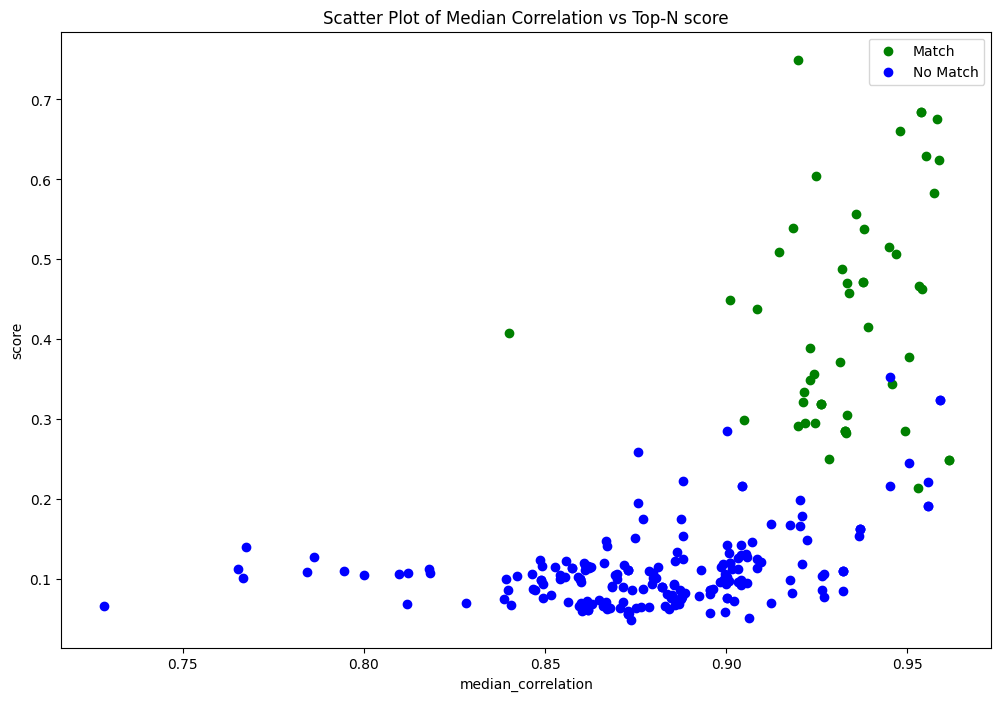

In [111]:
# Create a new column 'match' to indicate whether 'annotated_subtype' matches 'top5'
import matplotlib.pyplot as plt

merged_dfs['match'] = merged_dfs['annotated_subtype'] == merged_dfs['top5']


plt.figure(figsize=(12, 8))
for match_status, color, label in zip([True, False], ["green", "blue"], ["Match", "No Match"]):
    subset = merged_dfs[merged_dfs['match'] == match_status]
    plt.scatter(subset['median_correlation'],subset[0],  c=color, label=label)


plt.xlabel("median_correlation")
plt.ylabel("score")
plt.title("Scatter Plot of Median Correlation vs Top-N score")
plt.legend()
plt.show()